In [1]:
# Import fast.ai lib
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

# Import all the vision library
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

# 1 DATA PREPARATION


## 1.1 GATHERING DATA

There are several ways to get data. For non tabular data, we have to collect and organize the data to ease the training process. Here we will seperate 3 types of bear images in their own folder.

In [69]:
# For instance here we get pet images from fastai external source. Uncomment to use
#path = untar_data(URLs.PETS)/'images'

# Here we get grizzly bear images from duckduckgo image search, with a fastai image downloading function.
# Note that ims is a list of the 200 URLs of the images, they are not downloaded yet. We'll download other bear types
# images on the next step
ims = search_images_ddg('grizzly bear')

# Now let's create a folder tree and download images of more specific bears
bear_types = 'grizzly','black','teddy'
pathbear = Path('bears')

if not path.exists():
    pathbear.mkdir()
    for b in bear_types:
        dest = path/b
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{b} bear')
        # download_images is a fastai function downloading images from a list of URLs
        download_images(dest, urls=results)

## 1.2 DATALOADERS

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [70]:
dls = bears.dataloaders(pathbear)

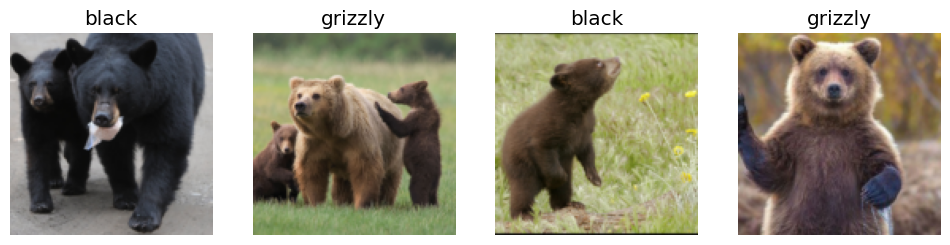

In [71]:
dls.valid.show_batch(max_n=4, nrows=1)

# 1.3 Image standardification

In [72]:
We need to make all the images the same size. Several methods for that resizing exist. Squishing,
padding with black (zeros), or cropping; For cropping, we can do it different ways (random cropping, center, ...)

SyntaxError: invalid syntax (2972932422.py, line 1)

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## 1.4 DATA AUGMENTATION

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. This aims at making the model more polyvalent.
Fastai provides the `aug_transforms` function with executes a standard set of augmentations


In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# 2 DESIGN YOUR MODEL

Restart the kernel here otherwise it won't work

## 1.2 Prepare training and validation data and shape it for processing with the Model

If we used fastais  `fit()` function we would only need the Dataloaders
prepared on the previous section, be we will code the steps inside of `fit()` ourselves so we need 1 Dataloader for the training set and 1 other for the validation set

### 1.2.1 Training

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
# Define lists of images
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
# Put images into tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [11]:
# Stack all the threes and sevens into 1 tensor for each category,
# and divide by 255 to put the grey level between 0. and 1.

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

### 1.2.2 Validation

In [12]:
# We create the validation tensors from the valid folder. Same operations
# as before condensed in one line
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_7_tens.shape, valid_3_tens.shape

(torch.Size([1028, 28, 28]), torch.Size([1010, 28, 28]))

### 1.2.3 Gathering all data into single tensors
We already have our independent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [13]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [16]:
# On fait un tableau train_y de dimension 1 rempli de 1 aux index des 3,
# et de 0 aux index des 7. [[1],[1],...[0],[0]]
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
#We could also do this way
train_y2 = tensor([[1]]*len(threes) + [[0]]*len(sevens)) 

train_x.shape,train_y.shape, train_y2.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [17]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [18]:
# Same data preparation for validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

#### Dataloader creation


In [19]:
# Training dl
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

# Validation dl
valid_dl = DataLoader(valid_dset, batch_size=256)

#### Linear1 function
The linear1 function computes the matrix multiplication of the inputs and add the bias

In [20]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds, preds.shape

(tensor([[ -6.2330],
         [-10.6388],
         [-20.8865],
         ...,
         [-15.9176],
         [ -1.6866],
         [-11.3568]], grad_fn=<AddBackward0>),
 torch.Size([12396, 1]))

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [21]:
(preds>0.0)

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [22]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [23]:
# Now we compute the accuracy as the mean of the correctness
corrects.float().mean().item()

0.5379961133003235

### Compute the loss function
We need a function whose output improves (converges towards 0) when a small improvement of the parameters occured. Here outputting 1 means the model predicts a 3, and outputting 0 for 7

In [25]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #Flatten predictions within [0:1]
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Putting it all together

It's time to implement the process we saw in previously. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

In [54]:
# Initialize parameters
# Create a random tensor based on its inputs
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [55]:
# Create dataloaders
# 1 For training 
dl = DataLoader(dset, batch_size=256)

# 2 For Validation
valid_dl = DataLoader(valid_dset, batch_size=256)

# Check
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

#### Test 1 iteration of gradients update

In [56]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [57]:
preds = linear1(batch)
preds

tensor([[-11.1345],
        [ -3.4446],
        [ -9.7507],
        [-10.5177]], grad_fn=<AddBackward0>)

In [58]:
# Compute loss with the 4 corresponding Ys
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9922, grad_fn=<MeanBackward0>)

In [71]:
# Calculate gradients
# backward() will compute the gradients of all the inputs that were
# necessary to generate the `loss` variable
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. We'll see how this is done exactly in chapter <<chapter_foundations>>, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

In [60]:
# Let's put all of that in a function
# xb is a tensor of all the images of the batch
# yb is a tensor of all the target outputs of the batch
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [61]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0021), tensor([-0.0150]))

In [62]:
# Look what happens when called twice :

In [63]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0032), tensor([-0.0226]))

The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [64]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [65]:
def train_epoch(model, lr, dl, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [66]:
# Function to calculate our validation accuracy:
# xb is a tensor of all the predictions of the batch
# yb is a tensor of all the target outputs of the batch
def batch_accuracy(xb, yb): 
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [67]:
# Compute accuracy over all batches
def validate_epoch(model, valid_dl):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [68]:
# Let's train 1 epoch and see how our accuracy improves
lr = 1.
params = weights,bias
train_epoch(linear1, lr, dl, params)
validate_epoch(linear1, valid_dl)

0.6433

In [70]:
# Let's do more epochs:
for i in range(20):
    train_epoch(linear1, lr, dl, params)
    print(validate_epoch(linear1, valid_dl), end=' ')

0.9154 0.9383 0.951 0.9569 0.9598 0.9632 0.9661 0.969 0.9695 0.9715 0.9715 0.973 0.9744 0.9749 0.9769 0.9774 0.9788 0.9793 0.9798 0.9798 

## USING AN OPTIMIZER

In [80]:
# Example of what would be in an optimizer class that would do the
# tasks we saw in the previous section
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [74]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [75]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:
    

In [78]:
# Create optimizer
opt = SGD(linear_model.parameters(), lr)


In [81]:
# We can simplify our train epoch function with the optimizer functions
def train_epoch(model, dl): 
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [88]:
# Define a training function to loop over epochs
def train_model(model, dl, epochs):
    for i in range(epochs):
        train_epoch(model, dl)
        # Note that validate_Epoch did not need to change
        print(validate_epoch(model, valid_dl), end=' ')

In [89]:
# Now train
train_model(linear_model, dl, 20)

0.979 0.979 0.979 0.979 0.9795 0.98 0.98 0.9809 0.9809 0.9814 0.9819 0.9814 0.9809 0.9809 0.9809 0.9814 0.9814 0.9814 0.9814 0.9814 

## USING fit() FUNCTION

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [90]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `vision_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [91]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [92]:
# Now we can call fit():
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637162,0.503305,0.495584,00:00
1,0.471768,0.228473,0.796860,00:00
2,0.175296,0.161582,0.853288,00:00
3,0.077789,0.099770,0.916585,00:00
4,0.041858,0.074468,0.935721,00:00
5,0.027822,0.060392,0.947988,00:00
6,0.022042,0.051459,0.956330,00:00
7,0.019453,0.045450,0.964181,00:00
8,0.018123,0.041204,0.966143,00:00
9,0.017314,0.038058,0.968597,00:00


# IMPLEMENT A NEURAL NETWORK WITH NON LINEARITIES

See chapter 4 "Add a non-linearity"


In [93]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [94]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [97]:
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.323862,0.406561,0.506379,00:00
1,0.150597,0.232727,0.795388,00:00
2,0.083055,0.117490,0.914132,00:00
3,0.054310,0.079166,0.941609,00:00
4,0.040996,0.061626,0.955839,00:00
5,0.034201,0.051762,0.962709,00:00
6,0.030298,0.045559,0.966143,00:00
7,0.027761,0.041331,0.967125,00:00
8,0.025935,0.038264,0.968597,00:00
9,0.024521,0.035930,0.969087,00:00


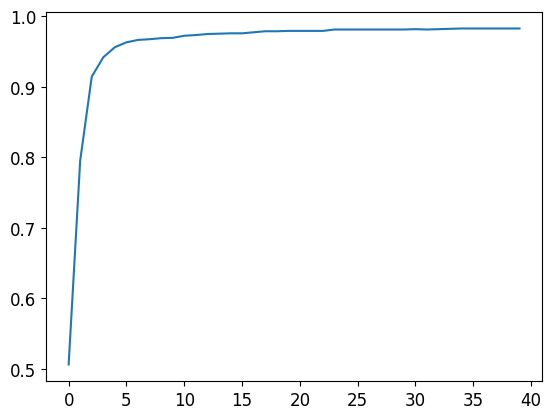

In [98]:
# Plot accurary over training
plt.plot(L(learn.recorder.values).itemgot(2));

In [99]:
# Final accuracy
learn.recorder.values[-1][2]

0.98233562707901

## Trying with more layers : resnet18

In [100]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.095654,0.018980,0.995584,01:57
